# Paper figure: Cloned model comparison

March 2022

gully


The goal of the notebook is to make a figure for the paper showing how we clone the precomputed synthetic model.

In [1]:
%config Completer.use_jedi = False

In [2]:
import torch
from blase.emulator import PhoenixEmulator, SparsePhoenixEmulator
import matplotlib.pyplot as plt
from gollum.phoenix import PHOENIXSpectrum
import numpy as np
from tqdm.notebook import tqdm
import os

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
    
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
device

'cuda'

### Retrieve the Phoenix model

In [4]:
spectrum = PHOENIXSpectrum(teff=4700, logg=4.5)#, wl_lo=8019, wl_hi=12845)
spectrum = spectrum.divide_by_blackbody()
spectrum = spectrum.normalize()
continuum_fit = spectrum.fit_continuum(polyorder=5)
spectrum = spectrum.divide(continuum_fit, handle_meta="ff")

In [5]:
# Numpy arrays: 1 x N_pix
wl_native = spectrum.wavelength.value
flux_native = spectrum.flux.value

### Clone the model

In [6]:
emulator = SparsePhoenixEmulator(wl_native, flux_native, prominence=0.01)

Initializing a sparse model with 9028 spectral lines


In [7]:
emulator.to(device)

SparsePhoenixEmulator()

In [8]:
import copy

In [9]:
state_dict_init = copy.deepcopy(emulator.state_dict())

In [10]:
state_dict_init['lam_centers'].shape

torch.Size([9028])

In [11]:
state_dict_post = torch.load('../experiments/06_bare_emulator_clone/emulator_T4700g4p5_prom0p01_HPF_recovery.pt')

In [12]:
emulator_pre = copy.deepcopy(emulator)

In [13]:
emulator_post = copy.deepcopy(emulator)

In [14]:
emulator_post.load_state_dict(state_dict_post)

<All keys matched successfully>

In [15]:
%%time
with torch.no_grad():
    spec_out = emulator_post.forward().cpu().numpy()

CPU times: user 12.8 ms, sys: 4.16 ms, total: 16.9 ms
Wall time: 16.5 ms


In [16]:
import seaborn as sns

In [17]:
sns.set_context('paper', font_scale=1.3)

In [18]:
residual = flux_native - spec_out

In [21]:

wl_lo = 12423
wl_hi = 12441

## Get a spectrum of WASP-69

In [22]:
import pandas as pd

In [23]:
df = pd.read_csv('../../blimp/data/tables/003_goldilocks_PSU_dropbox_1081x30_v1p0.csv')

In [24]:
mask = df.OBJECT.str.contains('69')

In [25]:
df = df[mask].dropna().reset_index(drop=True)

In [26]:
df.OBJECT.value_counts()

WASP_69_in_2              7
WASP_69_out_2_before_4    4
WASP_69_out_1_before_4    4
WASP_69_out_2_before_3    3
WASP_69_out_2_before_1    1
Name: OBJECT, dtype: int64

In [27]:
base_path = '/media/gully/pecos/HPF/Dropbox/Helium-transit-data/'

In [28]:
df['absolute_path'] = base_path + df.dropbox_subfolder_Goldilocks + df.file_basename_Goldilocks

In [29]:
fn = df.absolute_path[0]

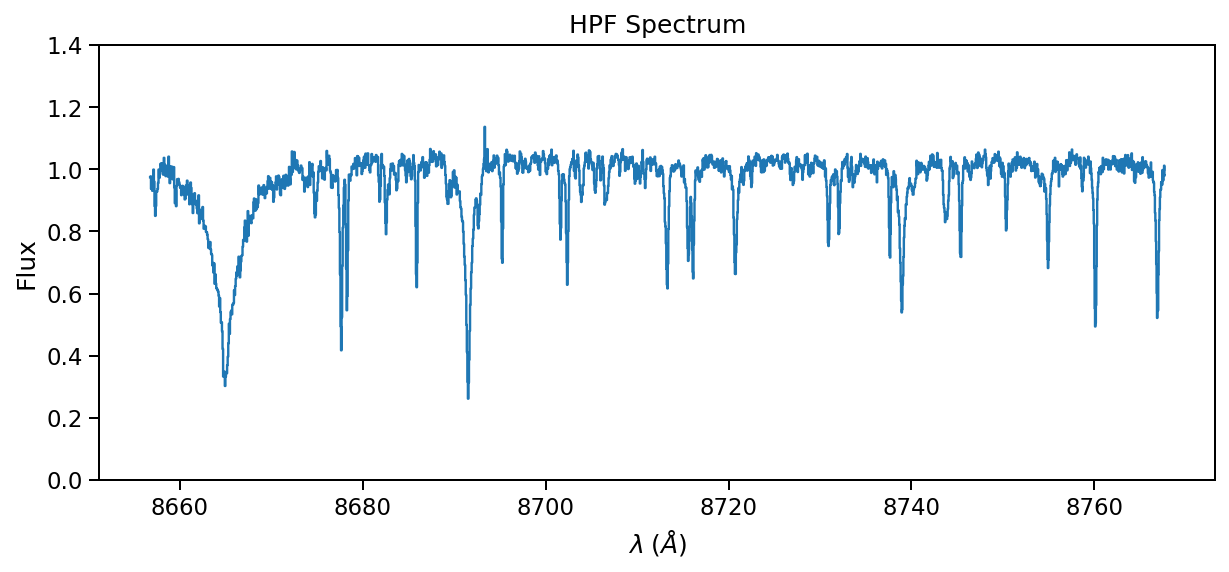

In [30]:
from muler.hpf import HPFSpectrum

data = HPFSpectrum(file=fn, order=5)

data = data.sky_subtract().deblaze().trim_edges((8, 2040)).normalize()
data = data.mask_tellurics(threshold=0.98)
ax = data.plot(ylo=0, yhi=1.4, label='data')


In [31]:
len(df)

19

In [32]:
data_list = []
for i, fn in enumerate(df.absolute_path.values):
    data = HPFSpectrum(file=fn, order=5)

    data = data.sky_subtract().deblaze().trim_edges((8, 2040)).barycentric_correct().normalize()
    data = data.mask_tellurics(threshold=0.98)
    data_list.append(data)

In [33]:
from muler.utilities import combine_spectra_misaligned

In [34]:
pixel_midpoints = HPFSpectrum(file=fn, order=5).wavelength.value

In [35]:
comb_spec = combine_spectra_misaligned(data_list, pixel_midpoints=pixel_midpoints)

<AxesSubplot:title={'center':'HPF Spectrum'}, xlabel='$\\lambda \\;(\\AA)$', ylabel='Flux'>

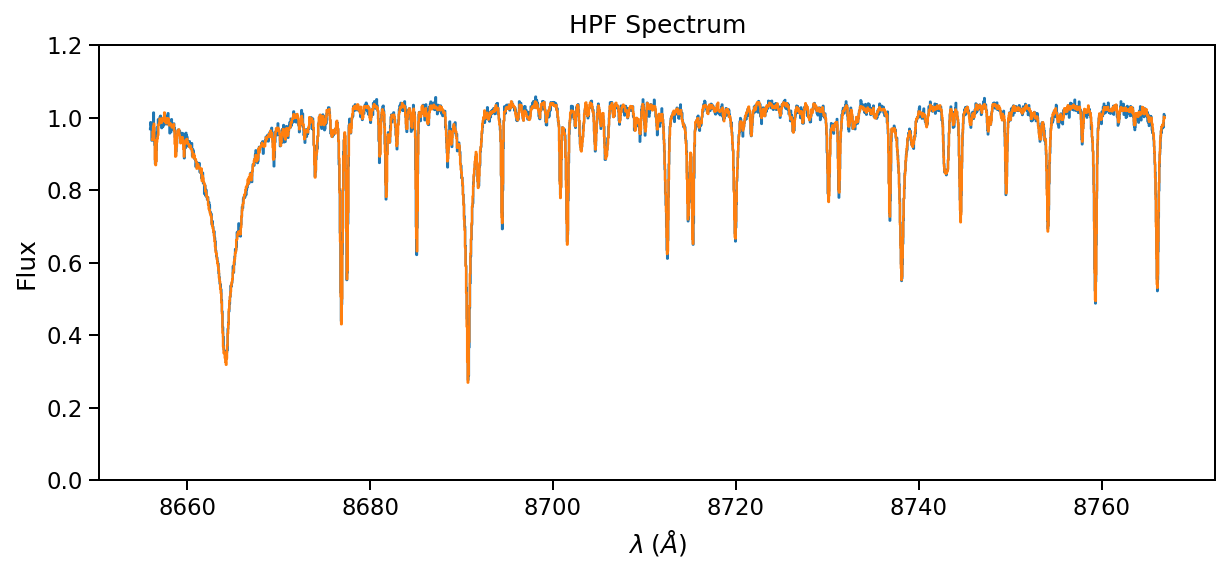

In [36]:
ax = data.plot(ylo=0)
comb_spec.plot(ax=ax)
#ax.set_xlim(8580, 8600)

In [37]:
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

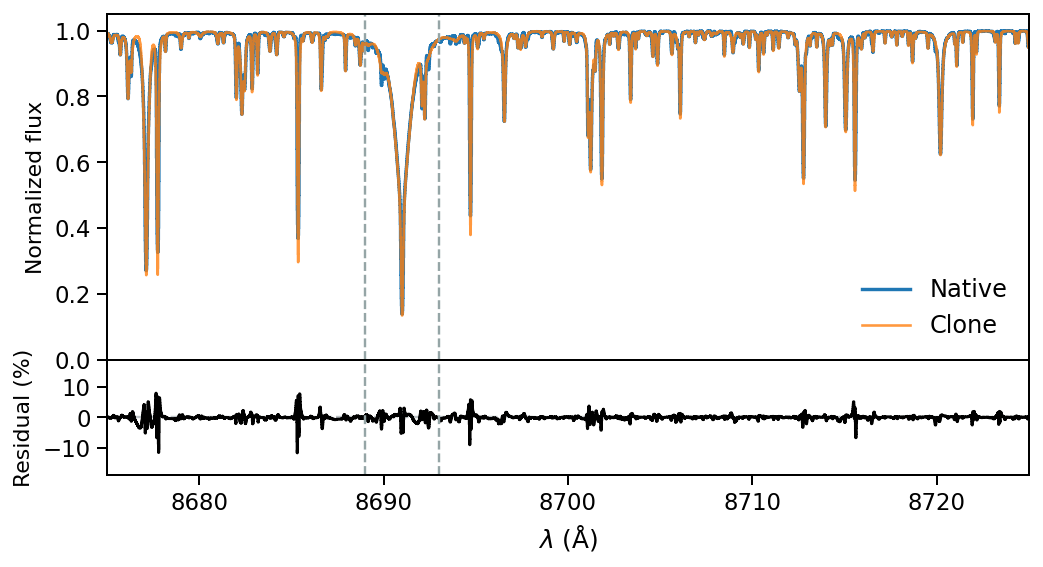

In [56]:
fig = plt.figure(figsize=(8, 4))

wl_lo = 8675#data.wavelength.value.min()+20
wl_hi = 8725#data.wavelength.value.max()-50

# Data - model comparison
ax = fig.add_axes((.1,.3,.8,.6))
ax.set_xticklabels([])
ax.step(wl_native, flux_native, alpha=1, lw=1.7, label='Native')
ax.step(wl_native, spec_out, alpha=0.8, lw=1.3, label='Clone')

ax.set_xlim(wl_lo, wl_hi)
ax.axvline(8689, linestyle='dashed', color='#95a5a6')
ax.axvline(8693, linestyle='dashed', color='#95a5a6')
ax.legend(fontsize=12, loc='best', ncol=1, frameon=False)
ax.set_ylim(-0.0001, 1.05)

ax.set_ylabel('Normalized flux', fontsize=11);

# Residual plot 
ax2=fig.add_axes((.1,.1,.8,.2))    
ax2.axhline(0, linestyle='dashed', color='#bdc3c7')
ax2.step(wl_native, residual*100, alpha=1, color='k', lw=1.5)
ax2.set_xlim(wl_lo, wl_hi)
ax2.set_ylim(-19, 19)
ax2.axvline(8689, linestyle='dashed', color='#95a5a6')
ax2.axvline(8693, linestyle='dashed', color='#95a5a6')
ax2.set_ylabel('Residual (%)', fontsize=11)
ax2.set_xlabel(r'$\lambda$ ($\mathrm{\AA}$)')
plt.savefig('../paper/paper1/figures/blase_clone_demo.png', bbox_inches='tight', dpi=300);

Nice!

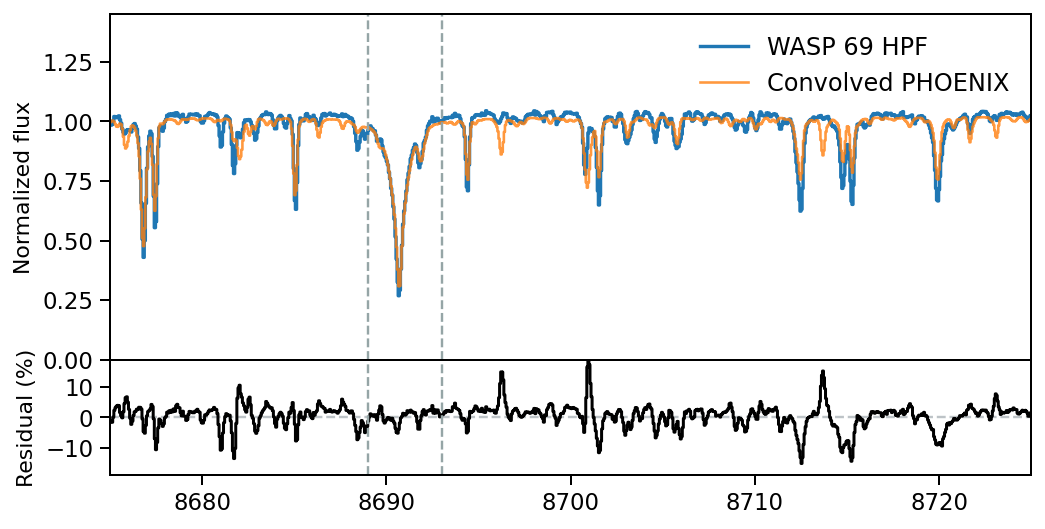

In [57]:
fig = plt.figure(figsize=(8, 4))

# Data - model comparison
ax = fig.add_axes((.1,.3,.8,.6))
ax.set_xticklabels([])
ax.step(comb_spec.wavelength, comb_spec.flux, alpha=1, lw=1.7, label='WASP 69 HPF')
adjusted_model = spectrum.rotationally_broaden(2.2).instrumental_broaden().rv_shift(-9.6).resample(comb_spec).normalize()
ax.step(adjusted_model.wavelength, adjusted_model.flux, alpha=0.8, lw=1.3, label='Convolved PHOENIX')

ax.set_xlim(wl_lo, wl_hi)
ax.axvline(8689, linestyle='dashed', color='#95a5a6')
ax.axvline(8693, linestyle='dashed', color='#95a5a6')
ax.legend(fontsize=12, loc='best', ncol=1, frameon=False)
ax.set_ylim(-0.0001, 1.45)

ax.set_ylabel('Normalized flux', fontsize=11);

# Residual plot 
resid = comb_spec - adjusted_model

ax2=fig.add_axes((.1,.1,.8,.2))    
ax2.axhline(0, linestyle='dashed', color='#bdc3c7')
ax2.step(resid.wavelength, resid.flux.value*100, alpha=1, color='k', lw=1.5)
ax2.set_xlim(wl_lo, wl_hi)
ax2.set_ylim(-19, 19)
ax2.axvline(8689, linestyle='dashed', color='#95a5a6')
ax2.axvline(8693, linestyle='dashed', color='#95a5a6')
ax2.set_ylabel('Residual (%)', fontsize=11)
plt.savefig('../paper/paper1/figures/blase_WASP69_demo.png', bbox_inches='tight', dpi=300);

All done!

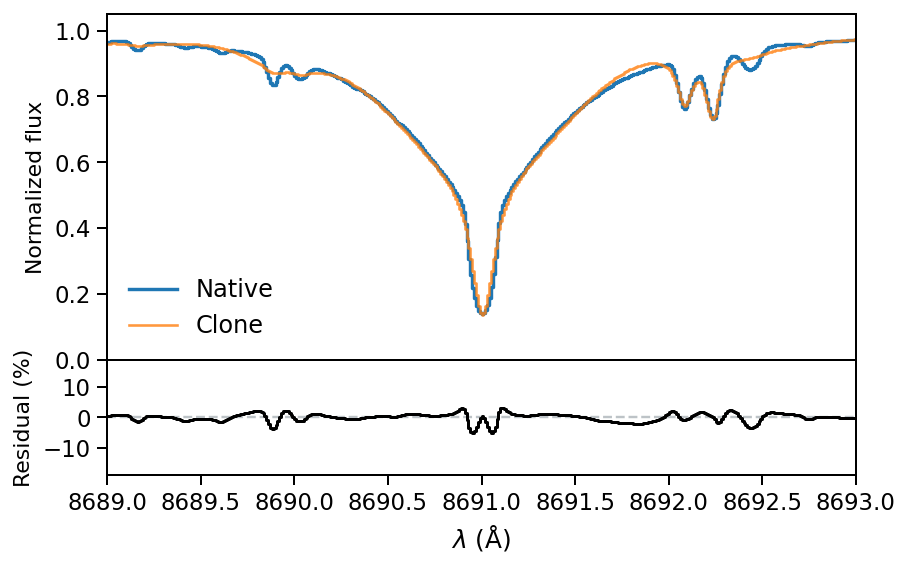

In [55]:
fig = plt.figure(figsize=(6.5, 4))

# Data - model comparison
ax = fig.add_axes((.1,.3,.8,.6))
ax.set_xticklabels([])
ax.step(wl_native, flux_native, alpha=1, lw=1.7, label='Native')
ax.step(wl_native, spec_out, alpha=0.8, lw=1.3, label='Clone')

ax.set_xlim(8689, 8693)
ax.legend(fontsize=12, loc='best', ncol=1, frameon=False)
ax.set_ylim(-0.0001, 1.05)

ax.set_ylabel('Normalized flux', fontsize=11);

# Residual plot 
ax2=fig.add_axes((.1,.1,.8,.2))    
ax2.axhline(0, linestyle='dashed', color='#bdc3c7')
ax2.step(wl_native, residual*100, alpha=1, color='k', lw=1.5)
ax2.set_xlim(8689, 8693)
ax2.set_ylim(-19, 19)
ax2.set_ylabel('Residual (%)', fontsize=11)
ax2.set_xlabel(r'$\lambda$ ($\mathrm{\AA}$)')
plt.savefig('../paper/paper1/figures/blase_clone_demo_zoom.png', bbox_inches='tight', dpi=300);

In [51]:
wl0 = emulator.lam_centers.detach().cpu().numpy()

In [58]:
mask = (wl0 < wl_hi) & (wl0 >wl_lo)

In [59]:
mask.sum()

121

In [60]:
mask = (wl0 < 8693) & (wl0 >8689)
mask.sum()

7

In [27]:
73/0.007

10428.571428571428

In [28]:
pixels = (wl_native < 8693) & (wl_native >8689)

In [29]:
pixels.sum()

399

In [61]:
mask = (wl_native > wl_lo) &(wl_native < wl_hi)
mask.sum() / len(wl_native)

0.014761596815581915